In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import pandas as pd
import itertools
import seaborn as sns

In [2]:
import seaborn as sns
import json
import pandas as pd
import numpy as np

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# plt.rcParams['axes.linewidth'] = 2.0 #set the value globally
# sns.set(style="whitegrid")
sns.set_style("whitegrid")
# Load results
sns.set(font_scale=1.7)
sns.set_style("darkgrid")

def read_json(path):
    validation = []
    with open(path, "r") as f:
        for line in f:
            line=line.strip().replace("'", '"')
            line = line.replace("nan", '"nan"')
            try:
                data = json.loads(line)
            except:
                print(line)
                raise
            if data['_meta']['type'] == 'validation':
                validation.append(data)
    return validation

                    
def transform(entry, atk, agg, m, s, d, b, bz):
    if "large" in atk:
        atk_name = r"IPM ($\epsilon = 100$)"
    elif atk == "IPM":
        atk_name = r"IPM ($\epsilon = 0.5$)"
    else:
        atk_name = atk
        
    if b == 0:
        atk_name = "No Attack"
        
    return {
        'Round Number': entry['E'],
        'Accuracy (%)': entry['top1'],
        'ATK': atk_name,
        "Batch Size": bz,
        'Setting': d.replace('f', 'F', 1),
        'AGG': fedavg_methods[agg]['name'],
        r"$\beta$": m,
        'seed': s,
        r"$M$" : b,
        r"$\delta=0$": False,
    }

b=8

attacks = ["Noise", "BF", "LF", "IPM", 'IPM_large', "ALIE"]
aggs = ["avg", "krum", 'rfa', "autogm", "cm", "tm", "cp", "clustering", 'clippedclustering']
aggs = ["krum", 'rfa', "autogm", "cm", "tm", "cp", "clustering", 'clippedclustering']

fedavg_methods = {
    'avg' : {'name' : 'Mean', 'marker' : '^'}, 
    'rfa' : {'name' : 'GeoMed', 'marker' : 's'}, 
    'autogm' : {'name' : 'AutoGM', 'marker' : 's'}, 
    'krum' : {'name' : 'Krum', 'marker' : '|'}, 
    'cp' : {'name' : 'CC', 'marker' : 'p'}, 
    'cm': {'name' : 'Median', 'marker' : 'D'}, 
    'tm' : {'name' : 'TrimmedMean', 'marker' : '8'}, 
    'clustering' : {'name' : 'Clustering', 'marker' : 'o'}, 
    'clippedclustering' : {'name' : 'ClippedClustering', 'marker' : 'v'}
}

col_order = [fedavg_methods[k]['name'] for k in aggs]

def append_loop_path(bs, seeds, attacks, aggs, ms, dir_name, data_collection, ROOT_PATH, bzs=None):
    if not bzs:
        bzs = [32]
    for bz in bzs:
        for b in bs:
            for seed in seeds: 
                for attack in attacks:
                    for agg in aggs:
                        for m in ms:
                            try:
                                batch_size = '_bz' + str(bz) if bz != 32 else ""
                                path = ROOT_PATH.format(d=dir_name, f=b, atk=attack, agg=agg, m=m, b=b, bz=batch_size, s=seed)
                                data_collection[path] = read_json(path)
                                if len(data_collection[path]) < 150:
                                    print(path)
                            except Exception as e:
                                print(e)
                                raise 
    return data_collection

def append_loop_df(bs, seeds, attacks, aggs, ms, dir_name, df, ROOT_PATH, data_collection, bzs=None):
    if not bzs:
        bzs = [32]
    for bz in bzs:
        for b in bs:
            for seed in seeds: 
                for attack in attacks:
                    for agg in aggs:
                        for m in ms:
                            try:
                                batch_size = '_bz' + str(bz) if bz != 32 else ""
                                path = ROOT_PATH.format(d=dir_name, f=b, atk=attack, agg=agg, m=m, b=b, bz=batch_size, s=seed)
                                validation_entries = data_collection[path]
                                df += list(map(lambda x: transform(x, atk=attack, agg=agg, m=m, s=seed, d=dir_name, b=b, bz=bz), validation_entries))
                            except Exception as e:
                                print("Error", e)
                                raise
    return df

def plot_all(dir_name, num_round=7500):
    ROOT_PATH="../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}_seed{s}/stats" #% (dir_name)
    data_collection = {}
    
    data_collection = append_loop_path(bs=[8], seeds=[0], attacks=attacks, aggs=aggs, 
                    ms=[0.0], dir_name=dir_name, data_collection=data_collection, ROOT_PATH=ROOT_PATH)

    
    data_collection = append_loop_path(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=aggs, 
                    ms=[0.0], dir_name=dir_name, data_collection=data_collection, ROOT_PATH=ROOT_PATH)


    df = []
    df = append_loop_df(bs=[8], seeds=[0], attacks=attacks, aggs=aggs, 
                    ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    df = pd.DataFrame(df)
    
    
    df_noattack = []
    df_noattack = append_loop_df(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=aggs, 
            ms=[0.0], dir_name=dir_name, df=df_noattack, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    df_noattack = pd.DataFrame(df_noattack)

    
    data = pd.concat([df_noattack, df],ignore_index=True)
    
    data.loc[(data["Setting"] == "Fedsgd_iid") | (data["Setting"] == "Fedsgd_noniid"), "Round Number"] *= 50
    data["Communication Rounds"] = data["Round Number"]
    g = sns.relplot(
        data=data, 
        x="Communication Rounds", y="Accuracy (%)", 
        col="AGG", 
    #     row=r"$\beta$", 
        hue="ATK", 
    #     style=r"$\delta=0$",
        height=4.5, aspect=1.25,
        col_order=col_order,
        markers=True,
        col_wrap=4,
        
        linewidth = 3.0,
        kind="line"
    )
#     g.set(xlim=(0, num_round))


    sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.05), ncol=8, title=None, frameon=False)

    g.savefig(dir_name + ".pdf", bbox_inches = "tight") 

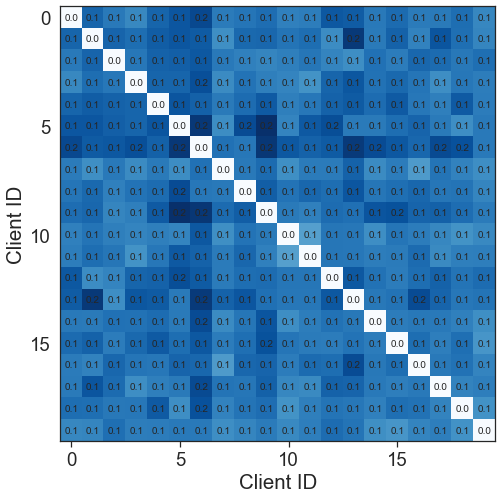

In [3]:
import numpy as np
import matplotlib.pyplot as plt

sns.set_style("white")
fig, ax = plt.subplots(figsize=(8,8))

sim_avg_iid = np.load('updates_fedavg_iid.npy')
intersection_matrix = 1-sim_avg_iid

ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

for i in range(intersection_matrix.shape[0]):
    for j in range(intersection_matrix.shape[0]):
        c = np.around(intersection_matrix[j,i], 1)
        ax.text(i, j, str(c), va='center', ha='center', fontsize=10)

# ax.set_xticklabels(range(sim_avg_iid.shape[0]), fontsize=10)  
# ax.set_yticklabels('')
ax.set_ylabel('Client ID')
ax.set_xlabel('Client ID')
ax.xaxis.set_ticks_position('bottom')
plt.savefig("cosine.pdf", bbox_inches = "tight")

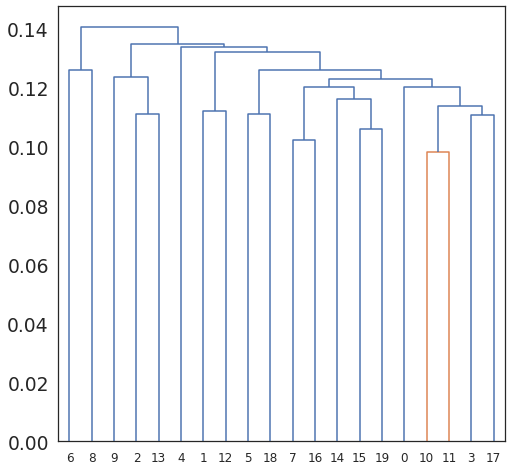

In [7]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(affinity='precomputed', compute_distances=True, linkage='average', n_clusters=2)
model.fit(intersection_matrix)
fig, ax = plt.subplots(figsize=(8,8))
plot_dendrogram(model, truncate_mode="level", p=10)
plt.savefig("shc.pdf", bbox_inches = "tight")
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()